## Introduction

Experiments were conducted on RUSBoost model to find its generalization and the impact of randomizing distribution of training and test data.

## Description


Data Distribution
>- 2 kinds of data was used
>>- Paper's distribution. 1991-2005 as training dataset and 2006-2012 as testing dataset.
>>- Random distribution of 80/20 split.

Serial Data:
>- Best model of RUSBoost, with 600 estimators was trained on both dataset, Raw and Ratio, from paper's distribution.
>- Both models gave approx same recall of 0.5 on negative class and 0.8 on positive class.
>- But the AUC of Raw dataset (0.733) was slightly higher than AUC of Ratio dataset (0.728).

Random Data:
>- A split of 80/20 was used for training and testing respectively with random_seed as 42 for consistent results.
>- A subset of data with years 1991-2012 was used for consistency.
>- AUC for random data was seemed to be higher that was 0.802 for Ratios data and 0.792 for Raw data. 
>- Although AUC was a bit higher, recall seemed to be approx 0.5 for negative class and 0.8 for positive class.
>- Nonetheless, Random distribution seemed a bit better, which led to second experiment.

Best number of estimators for Random Sampling:
>- This experiment was only performed on Ratio data.
>- Best AUC we got was 0.827750 with TPR:0.85714 and FPR:0.355859. Much better than before.
>- Best no. of estimators was 350 for random sampling with recall of 0.70 for negative cases and 0.75 for positive cases and 0.811 AUC.
>- For same model 5 iterations were run to see whether the model was generalizing and since the results were consistent for different random distribution, it seemed the model was generalizing well.

Results with PRCC_F(Price Close-Annual-Fiscal):
>- We realized that PRCC_F was sharing the info from the future, therefore our model was biased. Hence 2 models were trained, with and with PRCC_F.
>- Shockingly, the results doesn't seem to vary much.


## Conclusions

It seemed Random distribution was performing well than the serial data. Secondly, the data seemed to generalize well. Further Hypertuning may result in better performance. Lastly, PRCC_F didn't seem to have much effect.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from RUSBoost.rusboost import *
%matplotlib inline

In [11]:
def plot_cm(cm):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(cm, annot=True,cmap="OrRd",fmt='g')
    plt.title('confusion matrix')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.show()

In [12]:
# reading raw data
df_raw = pd.read_csv('../Dataset/university_data/uni_fraud.csv',sep = ';')
df_c = df_raw[['g_id','fyear','fraud','act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib', 'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale', 'sstk', 'txp', 'txt', 'xint', 'prcc_f']]
df_c.head()

,g_id,fyear,fraud,act,ap,at,ceq,che,cogs,csho,...,ppegt,pstk,re,rect,sale,sstk,txp,txt,xint,prcc_f
0,100001990,1990.0,0.0,320.933,32.721,422.099,151.035,15.801,309.272,13.120,...,127.824,0.0,124.587,81.173,507.820,0.012,0.561,1.932,18.941,7.625
1,100001991,1991.0,0.0,291.493,33.937,392.755,155.328,24.042,338.654,13.122,...,132.961,0.0,128.735,78.314,534.808,0.020,0.493,1.177,17.172,9.875
2,100001992,1992.0,0.0,265.317,27.145,374.930,161.128,17.025,336.882,13.122,...,144.461,0.0,134.430,83.788,535.553,0.020,1.762,1.942,12.339,13.375
3,100001993,1993.0,0.0,303.795,41.373,423.337,178.183,12.356,363.065,13.305,...,155.862,0.0,149.559,97.754,582.851,5.086,4.617,8.207,12.344,26.375
4,100001994,1994.0,0.0,335.913,31.559,469.387,195.089,8.814,404.679,13.121,...,167.356,0.0,169.856,117.002,640.810,0.538,0.000,11.732,12.288,19.625


In [13]:
# reading ratio dataset
df = pd.read_csv("Dataset/uni_ratios_fraud.csv",sep = ';')
df.head()

,g_id,fyear,gvkey,fraud,sale_flag,at_flag,sale/at,at/sale,act/sale,act/at,...,sstk/sale,sstk/at,txp/sale,txp/at,txt/sale,txt/at,xint/sale,xint/at,prcc_f/sale,prcc_f/at
0,100001990,1990.0,10000.0,0.0,0,0,1.203083,0.831198,0.631982,0.760326,...,0.000024,0.000028,0.001105,0.001329,0.003804,0.004577,0.037299,0.044873,0.015015,0.018064
1,100001991,1991.0,10000.0,0.0,0,0,1.361683,0.734385,0.545042,0.742175,...,0.000037,0.000051,0.000922,0.001255,0.002201,0.002997,0.032109,0.043722,0.018465,0.025143
2,100001992,1992.0,10000.0,0.0,0,0,1.428408,0.700080,0.495408,0.707644,...,0.000037,0.000053,0.003290,0.004700,0.003626,0.005180,0.023040,0.032910,0.024974,0.035673
3,100001993,1993.0,10000.0,0.0,0,0,1.376801,0.726321,0.521222,0.717620,...,0.008726,0.012014,0.007921,0.010906,0.014081,0.019386,0.021179,0.029159,0.045252,0.062303
4,100001994,1994.0,10000.0,0.0,0,0,1.365206,0.732490,0.524201,0.715642,...,0.000840,0.001146,0.000000,0.000000,0.018308,0.024994,0.019176,0.026179,0.030625,0.041810


## Experiment between paper's distribution and random of training and testing data.


#### Model which performed best according to model experiment notebook was used for both cases. To keep the comparison fair, we used same ratio of training and testing dataset for both serial and random.

### Serial Data

#### Serial Data preparation

In [15]:
df_c.fyear.unique()

array([1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
       1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011., 2012., 2014., 2013.])

In [16]:
years = np.arange(1991,2006)
test_years = np.arange(2006,2013)

In [17]:
X_train = df[df.fyear.isin(years)]
X_raw_train = df_c[df_c.fyear.isin(years)]

y_train = X_train.fraud
y_raw_train = X_raw_train.fraud

X_train.drop(['g_id','fyear','gvkey','fraud'],axis = 1,inplace = True)
X_raw_train.drop(['g_id','fyear','fraud'],axis = 1,inplace = True)

C:\Users\umaid\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
X_test = df[df.fyear.isin(test_years)]
X_raw_test = df_c[df_c.fyear.isin(test_years)]

y_test = X_test.fraud
y_raw_test = X_raw_test.fraud

X_test.drop(['g_id','fyear','gvkey','fraud'],axis = 1,inplace = True)
X_raw_test.drop(['g_id','fyear','fraud'],axis = 1,inplace = True)

In [19]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler_raw = preprocessing.StandardScaler().fit(X_raw_train)
X_raw_train = scaler_raw.transform(X_raw_train)
X_raw_test = scaler_raw.transform(X_raw_test)

In [20]:
print('Non Fraud cases in Training set:',sum(y_train == 0))
print('Fraud cases in Training set:',sum(y_train == 1))

Non Fraud cases in Training set: 90263
Fraud cases in Training set: 748


In [21]:
print('Non Fraud cases in Testing set:',sum(y_test == 0))
print('Fraud cases in Testing set:',sum(y_test == 1))

Non Fraud cases in Testing set: 38992
Fraud cases in Testing set: 186


In [22]:
weight = sum(y_train == 0)/sum(y_train == 1)
weights = {0:1, 1:weight}

In [23]:
def ROC(y_test,probs):
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = f'AUC = {round(roc_auc,3)}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

##### Model performance on Ratio Dataset

In [67]:
# Using best RUSBoost Model
rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=600,learning_rate = 0.1,random_state = 42,min_ratio = 3)
rus.fit(X_train,y_train,minority_target=1)
y_pred = rus.predict(X_test)
probs = rus.predict_proba(X_test)

In [68]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[20860 18132]
 [   38   148]]
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.70     38992
         1.0       0.01      0.80      0.02       186

    accuracy                           0.54     39178
   macro avg       0.50      0.67      0.36     39178
weighted avg       0.99      0.54      0.69     39178



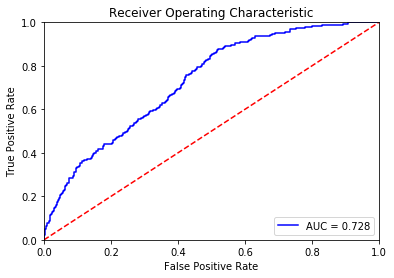

In [69]:
ROC(y_raw_test,probs[:,1])

#### Model performance on Raw Dataset

In [70]:
rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=600,learning_rate = 0.1,random_state = 42,min_ratio = 3)
rus.fit(X_raw_train,y_raw_train,minority_target=1)
y_pred = rus.predict(X_raw_test)
probs = rus.predict_proba(X_raw_test)

In [71]:
print(confusion_matrix(y_raw_test,y_pred))
print(classification_report(y_raw_test,y_pred))

[[19915 19077]
 [   30   156]]
              precision    recall  f1-score   support

         0.0       1.00      0.51      0.68     38992
         1.0       0.01      0.84      0.02       186

    accuracy                           0.51     39178
   macro avg       0.50      0.67      0.35     39178
weighted avg       0.99      0.51      0.67     39178



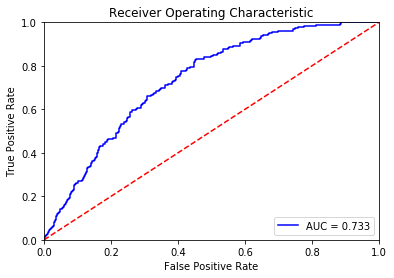

In [72]:
ROC(y_raw_test,probs[:,1])

### Conclusion : In terms of AUC, raw performed slightly better with a difference of 0.005

## Random Data

In [39]:
years = np.arange(1991,2013)

In [40]:
X_train = df.copy()
X_train = X_train[X_train.fyear.isin(years)]
X_raw_train = df_c.copy()
X_raw_train = X_raw_train[X_raw_train.fyear.isin(years)]

In [41]:
y_train = X_train.fraud
y_raw_train = X_raw_train.fraud

In [42]:
X_train.drop(['g_id','fyear','gvkey','fraud'],axis = 1,inplace = True)
X_raw_train.drop(['g_id','fyear','fraud'],axis = 1,inplace = True)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20,random_state = 42)
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw_train, y_raw_train, test_size = 0.20,random_state = 42)

In [44]:
# X_random_train, X_random_test, y_random_train, y_random_test = train_test_split(X_train, y_train, test_size = 0.2,random_state = 42)
# X_raw_random_train, X_raw_random_test, y_raw_random_train, y_raw_random_test = train_test_split(X_raw_random_train, y_raw_random_train, test_size = 0.43,random_state = 100)

In [45]:
print('Non Fraud cases in Training set:',sum(y_train == 0))
print('Fraud cases in Training set:',sum(y_train == 1))

Non Fraud cases in Training set: 103409
Fraud cases in Training set: 742


In [46]:
print('Non Fraud cases in Testing set:',sum(y_test == 0))
print('Fraud cases in Testing set:',sum(y_test == 1))

Non Fraud cases in Testing set: 25846
Fraud cases in Testing set: 192


#####  Model performance of Random Ratio Dataset

In [47]:
weight = sum(y_train == 0)/sum(y_train == 1)
weights = {0:1, 1:weight}

In [48]:
rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=600,learning_rate = 0.1,random_state = 42,min_ratio = 3)
rus.fit(X_train,y_train,minority_target=1)
y_pred = rus.predict(X_test)
probs = rus.predict_proba(X_test)

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.70     25846
         1.0       0.01      0.85      0.03       192

    accuracy                           0.54     26038
   macro avg       0.51      0.69      0.36     26038
weighted avg       0.99      0.54      0.69     26038



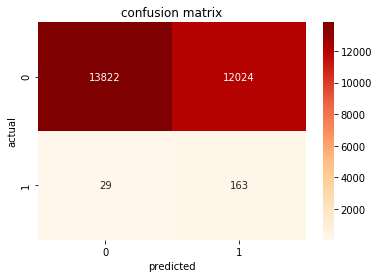

In [52]:
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))
plot_cm(cm)

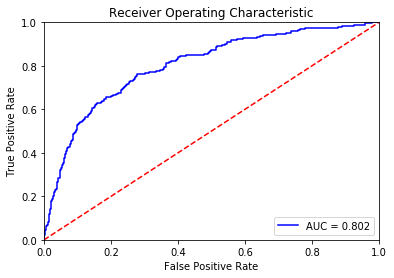

In [53]:
ROC(y_test,probs[:,1])

#####  Model performance of Random Raw Dataset

In [54]:
rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=600,learning_rate = 0.1,random_state = 42,min_ratio = 3)
rus.fit(X_raw_train,y_raw_train,minority_target=1)
y_pred = rus.predict(X_raw_test)
probs = rus.predict_proba(X_raw_test)

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69     25846
         1.0       0.01      0.85      0.03       192

    accuracy                           0.53     26038
   macro avg       0.51      0.69      0.36     26038
weighted avg       0.99      0.53      0.69     26038



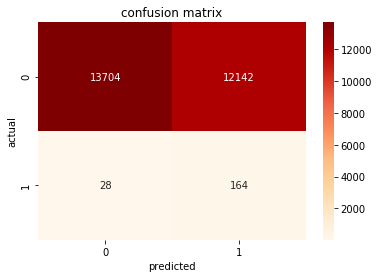

In [55]:
cm = confusion_matrix(y_raw_test,y_pred)
print(classification_report(y_raw_test,y_pred))
plot_cm(cm)

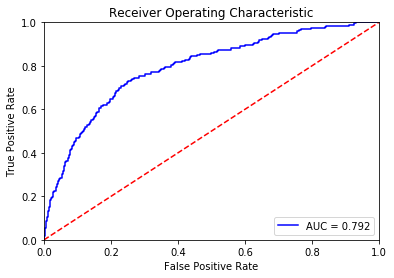

In [56]:
ROC(y_raw_test,probs[:,1])

#### Conclusion

In [57]:
AUC = {'serial_raw':[0.733],'serial_ratio':[0.728],'random_raw':[0.792],'random_ratio':[0.802]}
AUC = pd.DataFrame(AUC,index=['AUC'])
AUC

,serial_raw,serial_ratio,random_raw,random_ratio
AUC,0.733,0.728,0.792,0.802


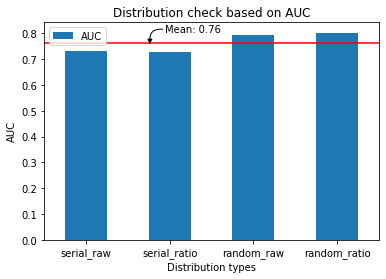

In [60]:
ax = AUC.T.plot(kind = 'bar',rot = 0)
mean = AUC.mean(axis = 1).values
ax.axhline(mean, color='red')
ax.annotate('Mean: {:0.2f}'.format(mean[0]), xy=(mean[0], 0.9), xytext=(15, 15),
            xycoords=('data', 'axes fraction'), textcoords='offset points', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'))

ax.set_ylabel('AUC')
ax.set_xlabel('Distribution types')
ax.set_title('Distribution check based on AUC')
plt.show()

##### - Random sampling performed slightly better
##### - AUC for all distribution wasn't far off from each other
##### - All models produced 0.5 recall for negative classes and 0.85 for positive class
##### - AUC doesn't seems to be a good measure and RUSBoost isn't performing that great

****

### Last RUSBoost Experiment with Random Ratio Dataset

#### Just to make sure of generalization and effect of random sampling, I performed last experiment.

In [61]:
def rates(y_test,y_pred):
    mat = confusion_matrix(y_test,y_pred)
    TPR = mat[1,1]/(mat[1,1] + mat[1,0]) # Recall (True positive rate)
    FPR = mat[0,1]/(mat[0,1]+mat[0,0]) # (False positive rate)
    return([TPR,FPR])

In [413]:
X_train = df.copy()
y_train = X_train.fraud
X_train.drop(['g_id','fyear','gvkey','fraud'],axis = 1,inplace = True)

In [414]:
X_random_train, X_random_test, y_random_train, y_random_test = train_test_split(X_train, y_train, test_size = 0.20,random_state = 42)

In [66]:
ROC = {'Train_TPR':[],'Train_FPR':[],'Train_AUC':[],'Test_TPR':[],'Test_FPR':[],
       'Train_AUC':[],'Test_AUC':[],'EST':[]}
for estimators in np.arange(50,1001,50):
    print('Estimators:',estimators)
    rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=estimators,learning_rate = 0.1,random_state = 42,min_ratio = 3)
    rus.fit(X_random_train,y_random_train,minority_target=1)
    
    test_pred = rus.predict(X_random_test)
    test_probs = rus.predict_proba(X_random_test)
    
    train_pred = rus.predict(X_random_train)
    train_probs = rus.predict_proba(X_random_train)
    
    test_preds = test_probs[:,1]
    train_preds = train_probs[:,1]
    
    test_fpr, test_tpr, test_threshold = metrics.roc_curve(y_random_test, test_preds)
    train_fpr, train_tpr, train_threshold = metrics.roc_curve(y_random_train, train_preds)
    
    test_roc_auc = metrics.auc(test_fpr, test_tpr)
    train_roc_auc = metrics.auc(train_fpr, train_tpr)
    
    test_rates_list = rates(y_random_test,test_pred)
    train_rates_list = rates(y_random_train,train_pred)
    
    ROC['Test_TPR'].append(test_rates_list[0])
    ROC['Test_FPR'].append(test_rates_list[1])
    
    ROC['Train_TPR'].append(train_rates_list[0])
    ROC['Train_FPR'].append(train_rates_list[1])
    
    ROC['Test_AUC'].append(test_roc_auc)
    ROC['Train_AUC'].append(train_roc_auc)
    
    ROC['EST'].append(estimators)

Estimators: 50
Estimators: 100
Estimators: 150
Estimators: 200
Estimators: 250
Estimators: 300
Estimators: 350
Estimators: 400
Estimators: 450
Estimators: 500
Estimators: 550
Estimators: 600
Estimators: 650
Estimators: 700
Estimators: 750
Estimators: 800
Estimators: 850
Estimators: 900
Estimators: 950
Estimators: 1000


In [67]:
ROC = pd.DataFrame(ROC)
ROC['diff'] = ROC['Test_TPR'] - ROC['Test_FPR']
ROC.sort_values('diff',ascending = False)

,Train_TPR,Train_FPR,Train_AUC,Test_TPR,Test_FPR,Test_AUC,EST,diff
7,1.000000,0.315881,0.990091,0.851429,0.322484,0.829847,400,0.528945
6,1.000000,0.281998,0.989979,0.805714,0.287077,0.824629,350,0.518637
5,1.000000,0.253578,0.989211,0.777143,0.261452,0.819944,300,0.515691
1,0.963245,0.204865,0.958425,0.720000,0.208790,0.814885,100,0.511210
8,1.000000,0.348023,0.990309,0.857143,0.355859,0.827750,450,0.501284
4,1.000000,0.221815,0.988230,0.725714,0.228456,0.819136,250,0.497258
3,1.000000,0.206580,0.984857,0.708571,0.212819,0.816428,200,0.495752
0,0.903676,0.237576,0.918426,0.737143,0.241682,0.809165,50,0.495461
9,1.000000,0.381432,0.989610,0.880000,0.388097,0.826175,500,0.491903
2,0.997465,0.196619,0.977709,0.674286,0.200351,0.807627,150,0.473934


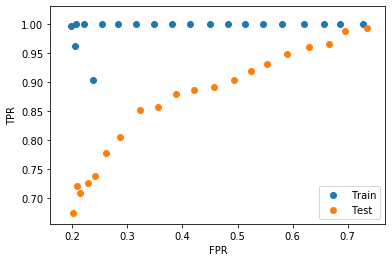

In [68]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(ROC.Train_FPR.values,ROC.Train_TPR.values, label='Train')
ax1.scatter(ROC.Test_FPR.values, ROC.Test_TPR.values, label='Test')

plt.legend(loc='lower right');
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### It seems that the best no. of estimators is 350 for random sampling with recall of 0.70 for negative cases and 0.75 for positive cases

In [326]:
# Selecting the model
rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=350,learning_rate = 0.1,random_state = 42,min_ratio = 3)
rus.fit(X_random_train,y_random_train,minority_target=1)

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83    103401
         1.0       0.02      1.00      0.05       750

    accuracy                           0.72    104151
   macro avg       0.51      0.86      0.44    104151
weighted avg       0.99      0.72      0.83    104151



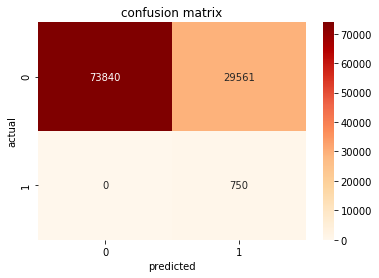

In [332]:
# Results on train dataset
X_random_pred = rus.predict(X_random_train)
cm = confusion_matrix(y_random_train,X_random_pred)
print(classification_report(y_random_train,X_random_pred))
plot_cm(cm)

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     25854
         1.0       0.02      0.77      0.04       184

    accuracy                           0.71     26038
   macro avg       0.51      0.74      0.43     26038
weighted avg       0.99      0.71      0.82     26038



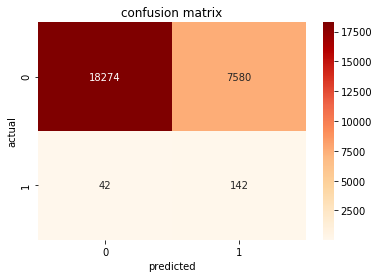

In [331]:
# Results on test dataset
y_random_pred = rus.predict(X_random_test)
print(classification_report(y_random_test,y_random_pred))
cm = confusion_matrix(y_random_test,y_random_pred)
plot_cm(cm)

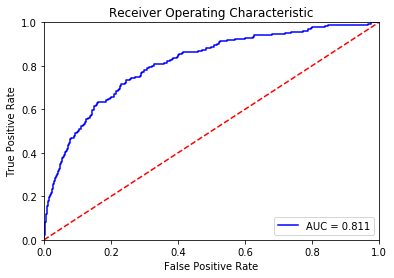

In [384]:
probs = rus.predict_proba(X_random_test)
ROC(y_random_test,probs[:,1])

****

#### Checking generalization of the model

In [335]:
ROC = {'Train_TPR':[],'Train_FPR':[],'Train_AUC':[],'Test_TPR':[],'Test_FPR':[],
       'Train_AUC':[],'Test_AUC':[],'True':[]}
for i in range(5):
    print('iteration:',i)
    X_random_train, X_random_test, y_random_train, y_random_test = train_test_split(X_train, y_train, test_size = 0.43)
    rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=350,learning_rate = 0.1,random_state = 42,min_ratio = 3)
    rus.fit(X_random_train,y_random_train,minority_target=1)
    
    test_pred = rus.predict(X_random_test)
    test_probs = rus.predict_proba(X_random_test)
    
    train_pred = rus.predict(X_random_train)
    train_probs = rus.predict_proba(X_random_train)
    
    test_preds = test_probs[:,1]
    train_preds = train_probs[:,1]
    
    test_fpr, test_tpr, test_threshold = metrics.roc_curve(y_random_test, test_preds)
    train_fpr, train_tpr, train_threshold = metrics.roc_curve(y_random_train, train_preds)
    
    test_roc_auc = metrics.auc(test_fpr, test_tpr)
    train_roc_auc = metrics.auc(train_fpr, train_tpr)
    
    test_rates_list = rates(y_random_test,test_pred)
    train_rates_list = rates(y_random_train,train_pred)
    
    ROC['Test_TPR'].append(test_rates_list[0])
    ROC['Test_FPR'].append(test_rates_list[1])
    
    ROC['Train_TPR'].append(train_rates_list[0])
    ROC['Train_FPR'].append(train_rates_list[1])
    
    ROC['Test_AUC'].append(test_roc_auc)
    ROC['Train_AUC'].append(train_roc_auc)
    
    ROC['True'].append(sum(y_random_train==1))

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4


In [371]:
ROC = pd.DataFrame(ROC)
mean = pd.DataFrame(ROC.mean(axis = 0))
mean = mean.T
mean.index = ['mean']
ROC.append(mean)

,Train_TPR,Train_FPR,Train_AUC,Test_TPR,Test_FPR,Test_AUC,True
0,1.0,0.311118,0.993440,0.776442,0.315841,0.801542,518.0
1,1.0,0.315906,0.995168,0.777778,0.316078,0.796155,511.0
2,1.0,0.304472,0.995917,0.770115,0.309360,0.802918,499.0
3,1.0,0.318087,0.995661,0.756440,0.322005,0.788558,507.0
4,1.0,0.328267,0.992446,0.794326,0.330496,0.805143,511.0
mean,1.0,0.315570,0.994526,0.775020,0.318756,0.798863,509.2


#### It seems with different random samples, results are consistent.

****

### Training model without PRCC_F

In [415]:
# Model with PRCC_F
rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=350,learning_rate = 0.1,random_state = 42,min_ratio = 3)
rus.fit(X_random_train,y_random_train,minority_target=1)

C:\Users\umaid\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


RUSBoost(base_estimator=RandomForestClassifier(class_weight={0: 1, 1: 137.868},
                                               max_depth=5, n_estimators=2),
         learning_rate=0.1, min_ratio=3, n_estimators=350, random_state=42,
         with_replacement=None)

In [416]:
without_prccf_Xtrain = X_train.drop(['prcc_f/sale','prcc_f/at'],axis = 1)
X_prccf_train, X_prccf_test, y_prccf_train, y_prccf_test = train_test_split(without_prccf_Xtrain, y_train, test_size = 0.20,random_state = 42)

In [417]:
# Model with PRCC_F
rus_without = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=350,learning_rate = 0.1,random_state = 42,min_ratio = 3)
rus_without.fit(X_prccf_train,y_prccf_train,minority_target=1)

C:\Users\umaid\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


RUSBoost(base_estimator=RandomForestClassifier(class_weight={0: 1, 1: 137.868},
                                               max_depth=5, n_estimators=2),
         learning_rate=0.1, min_ratio=3, n_estimators=350, random_state=42,
         with_replacement=None)

##### Results with PRCC_F

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     29034
         1.0       0.02      0.79      0.03       175

    accuracy                           0.71     29209
   macro avg       0.51      0.75      0.43     29209
weighted avg       0.99      0.71      0.83     29209



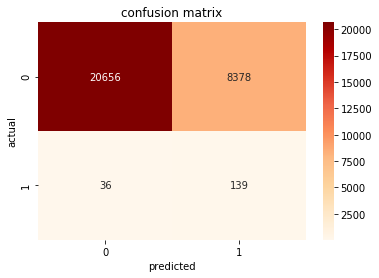

In [425]:
y_random_pred = rus.predict(X_random_test)
print(classification_report(y_random_test,y_random_pred))
cm = confusion_matrix(y_random_test,y_random_pred)
plot_cm(cm)

#### Results without PRCC_F

              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82     29034
         1.0       0.02      0.80      0.03       175

    accuracy                           0.70     29209
   macro avg       0.51      0.75      0.43     29209
weighted avg       0.99      0.70      0.82     29209



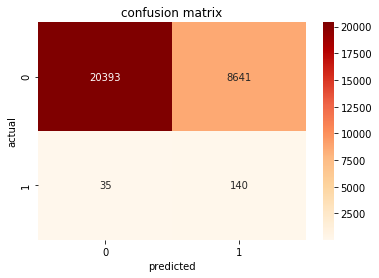

In [426]:
y_random_pred_without = rus_without.predict(X_prccf_test)
print(classification_report(y_prccf_test,y_random_pred_without))
cm = confusion_matrix(y_prccf_test,y_random_pred_without)
plot_cm(cm)